In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
path_base = '../data/processed/modeling_table_v2.parquet'
df_base = pd.read_parquet(path_base)
print(f"Tabela base de modelagem carregada com {df_base.shape[0]} registros.")

# Carregar o arquivo de dados climáticos
try:
    path_clima = '../data/raw/clima_go_diario.csv'
    df_clima_raw = pd.read_csv(path_clima)
    print(f"Dados de meteorologia carregados com {len(df_clima_raw)} registros.")
except FileNotFoundError:
    print("ERRO: Arquivo 'clima_go_diario.csv' não encontrado.")
    print("Por favor, execute o script 'scripts/download_weather_data.py' primeiro.")
    raise

Tabela base de modelagem carregada com 5722 registros.
Dados de meteorologia carregados com 5765 registros.


In [3]:
# Faz uma cópia para segurança
df_clima = df_clima_raw.copy()

# Converte a coluna 'data' para o formato datetime e a define como índice
df_clima['timestamp'] = pd.to_datetime(df_clima['data'])
df_clima.set_index('timestamp', inplace=True)

# Seleciona apenas as colunas que nos interessam
df_clima = df_clima[['ghi', 'temp2m_c', 'precipitacao_mm']]

print("Dados de meteorologia processados.")
display(df_clima.head())

Dados de meteorologia processados.


,ghi,temp2m_c,precipitacao_mm
timestamp,,,
2010-01-01,5.189250,23.0100,14.8000
2010-01-02,6.220275,23.2825,4.4450
2010-01-03,7.632525,23.9275,0.4125
2010-01-04,7.970825,24.4125,0.1775
2010-01-05,7.889325,25.2750,0.1750


In [4]:
# --- Unindo dados e criando features meteorológicas ---

# Começa com a nossa tabela de modelagem
df_final = df_base.copy()

# Adiciona as novas features de meteorologia
df_final = df_final.join(df_clima)

# Se houver alguma falha no download da API da NASA, preenchemos com o valor do dia anterior
df_final[['ghi', 'temp2m_c', 'precipitacao_mm']] = df_final[['ghi', 'temp2m_c', 'precipitacao_mm']].ffill().bfill()

# --- Engenharia de Features de Precipitação ---
print("Criando features de precipitação acumulada...")
# Soma da precipitação nos últimos 14 dias
df_final['precip_acumulada_14d'] = df_final['precipitacao_mm'].rolling(window=14).sum()
# Soma da precipitação nos últimos 30 dias
df_final['precip_acumulada_30d'] = df_final['precipitacao_mm'].rolling(window=30).sum()
print("Features de precipitação acumulada criadas com sucesso.")


# --- Tratamento de Nulos Gerados pelo Rolling Window ---
# As funções rolling() criam valores NaN no início do dataframe. Vamos removê-los.
print(f"\nShape ANTES de remover NaNs do rolling: {df_final.shape}")
df_final.dropna(inplace=True)
print(f"Shape DEPOIS de remover NaNs do rolling: {df_final.shape}")


print("\nValores nulos restantes nas novas colunas:", df_final[['ghi', 'precip_acumulada_14d']].isnull().sum().sum())
print("\nTabela final enriquecida com dados e features de meteorologia:")
display(df_final.head())

Criando features de precipitação acumulada...
Features de precipitação acumulada criadas com sucesso.

Shape ANTES de remover NaNs do rolling: (5722, 29)
Shape DEPOIS de remover NaNs do rolling: (5693, 29)

Valores nulos restantes nas novas colunas: 0

Tabela final enriquecida com dados e features de meteorologia:


,deficit_diario_mwh,nivel_risco,programada,verificada,diferenca_verif_prog,geracao_total_diaria_go,geracao_eolielétrica_diaria,geracao_fotovoltaica_diaria,geracao_hidroelétrica_diaria,geracao_nuclear_diaria,...,ear_diff_3d,margem_oferta_demanda,pressao_demanda_ear,cmo_semanal_seco,disponibilidade_total_diaria_go,ghi,temp2m_c,precipitacao_mm,precip_acumulada_14d,precip_acumulada_30d
timestamp,,,,,,,,,,,,,,,,,,,,,
2010-02-10,7.00,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.079994,0.0,0.0,20.69,66008.92373,6.356550,23.4150,5.7350,44.5025,128.0675
2010-02-11,0.00,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,20.69,66008.92373,5.414150,23.1925,4.9250,45.4575,129.4475
2010-02-12,0.00,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.070000,0.0,0.0,0.00,66008.92373,6.258125,23.6650,0.5475,41.4950,125.4625
2010-02-13,0.00,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.089996,0.0,0.0,0.00,66008.92373,6.123075,24.4625,0.9875,40.1350,121.9375
2010-02-14,0.75,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.080002,0.0,0.0,0.00,66008.92373,5.725550,24.4800,1.1650,40.2125,117.8125


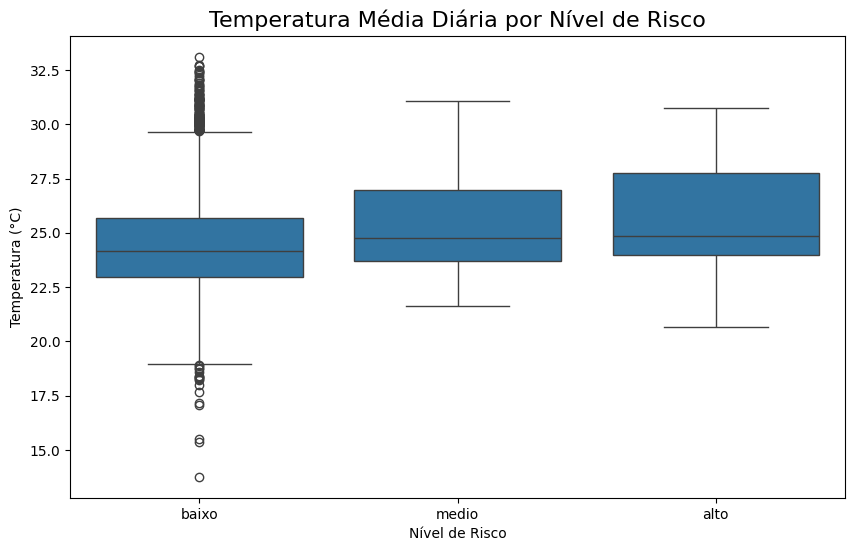

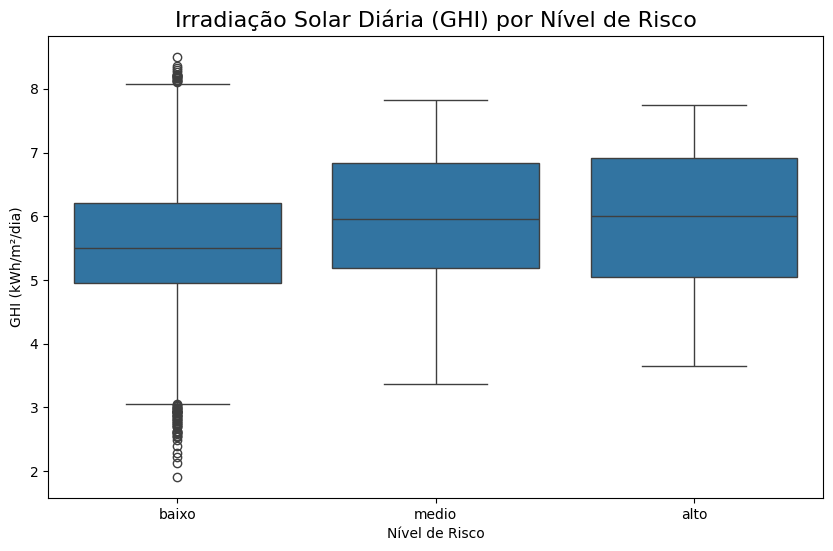

In [5]:
# Gráfico 1: Temperatura Média por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='temp2m_c', data=df_final, order=['baixo', 'medio', 'alto'])
plt.title('Temperatura Média Diária por Nível de Risco', fontsize=16)
plt.ylabel('Temperatura (°C)')
plt.xlabel('Nível de Risco')
plt.show()

# Gráfico 2: Irradiação Solar (GHI) por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='ghi', data=df_final, order=['baixo', 'medio', 'alto'])
plt.title('Irradiação Solar Diária (GHI) por Nível de Risco', fontsize=16)
plt.ylabel('GHI (kWh/m²/dia)')
plt.xlabel('Nível de Risco')
plt.show()

In [6]:
# Salvar a nova tabela, a mais completa de todas
output_path = '../data/processed/modeling_table_final.parquet'
df_final.to_parquet(output_path)
print(f"TABELA FINAL PARA MODELAGEM salva com sucesso em: {output_path}")

TABELA FINAL PARA MODELAGEM salva com sucesso em: ../data/processed/modeling_table_final.parquet
